# Monte Carlo: Lecture 7 Excercise
_Jose Javier Fernández González_

Variational Monte Carlo simulation of a harmonic oscillator

## Model

Taking the dimensionless Hamiltonian:

$$
\hat{H} = -\frac{1}{2} \sum ^N _{i=1} \frac{\delta ^2}{\delta x^2 _i} + \frac{1}{2} \sum ^N _{i=1} x ^2 _i + \sum _{i<j} \frac{q^2}{|x_i - x_j|} 
$$


with the wavefunction:

$$
\psi (x_1, \dots, x_N) = \prod _{i<j} |x_i - x_j|^\lambda \prod _k \exp{(-\alpha x^2 _k)}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Local Energy
def drift_and_second_derivatives(x, alpha, lam, eps=1e-12):
    N = x.shape[0]
    F = np.zeros(N, dtype=float)
    u2 = np.zeros(N, dtype=float)

    for i in range(N):
        dx = x[i] - x  # dx_j = xi - xj
        dx[i] = np.inf  # exclude self

        # if any pair too close -> singular; treat as forbidden configuration
        if np.any(np.abs(dx[np.isfinite(dx)]) < eps):
            return None, None

        inv = 1.0 / dx
        inv2 = inv * inv

        F[i] = lam * np.sum(inv[np.isfinite(inv)]) - 2.0 * alpha * x[i]
        u2[i] = -lam * np.sum(inv2[np.isfinite(inv2)]) - 2.0 * alpha

    return F, u2

def potential_terms(x, qtilde=1.0, eps=1e-12):
    N = x.shape[0]
    Vtrap = 0.5 * np.sum(x*x)
    Vc = 0.0
    for i in range(N-1):
        dx = np.abs(x[i+1:] - x[i])
        if np.any(dx < eps):
            return np.inf, np.inf, np.inf
        Vc += (qtilde*qtilde / dx).sum()
    return Vtrap + Vc, Vtrap, Vc

def local_energy_estimators(x, alpha, lam, qtilde=1.0, eps=1e-12):
    F, u2 = drift_and_second_derivatives(x, alpha, lam, eps=eps)
    if F is None:
        return np.inf, np.inf, np.inf, np.inf, np.inf

    V, Vtrap, Vc = potential_terms(x, qtilde=qtilde, eps=eps)
    if not np.isfinite(V):
        return np.inf, np.inf, np.inf, np.inf, np.inf

    F2sum = np.sum(F*F)
    u2sum = np.sum(u2)

    K1 = -0.5 * (u2sum + F2sum)   # direct / Laplacian
    K2 =  0.5 * F2sum             # drift-force estimator

    E1 = K1 + V
    E2 = K2 + V
    return E1, E2, K1, K2, V

## Simulation

In [3]:
# Helper functions

def gen_intial_config(N, spread=1.0):
    return spread * np.random.randn(N)

def move_points(x, delta=0.5):
    N = x.shape[0]
    i = np.random.randint(N)
    x_new = x.copy()
    x_new[i] += (2*np.random.random() - 1) * delta
    return x_new, i

def u_logpsi(x, alpha, lam, eps=1e-12):
    N = x.shape[0]
    # pair log term
    s = 0.0
    for i in range(N-1):
        dx = np.abs(x[i+1:] - x[i])
        if np.any(dx < eps):
            return -np.inf  # overlap -> ψ=0 effectively
        s += np.log(dx).sum()
    return lam * s - alpha * np.sum(x*x)

def log_prob(x, alpha, lam, eps=1e-12):
    u = u_logpsi(x, alpha, lam, eps=eps)
    return 2.0 * u

def delta_logpsi_local(x_old, x_new, k, alpha, beta, eps=1e-12):
    # one-body change
    du_1b = -alpha * (x_new[k]**2 - x_old[k]**2)

    # pair change (only pairs involving k)
    dx_old = np.abs(x_old[k] - np.delete(x_old, k))
    dx_new = np.abs(x_new[k] - np.delete(x_new, k))

    if np.any(dx_new < eps):
        return -np.inf  # forbidden overlap

    du_pair = beta * (np.log(dx_new).sum() - np.log(dx_old).sum())

    return du_1b + du_pair


# Metropolis
def metropolis_step_local(x, x_new, k, alpha, beta):
    du = delta_logpsi_local(x, x_new, k, alpha, beta)
    if not np.isfinite(du):
        return x, 0
    logw = 2.0 * du
    if logw >= 0 or np.random.random() < np.exp(logw):
        return x_new, 1
    return x, 0


In [4]:
# Main simulation
def run_sim(
    N=10,
    qtilde=1.0,
    alpha=0.5,
    lam=0.5,
    num_steps=200_000,
    delta=0.5,
    burn_in=None,
    sample_every=2,
    density_bins=200,
    density_xmax=6.0,
    eps=1e-10,
    ):
    if burn_in is None:
        burn_in = num_steps // 4

    x = gen_intial_config(N, spread=1.0)

    accepted = 0
    E1_list, E2_list = [], []
    K1_list, K2_list = [], []
    V_list = []

    # density histogram (one-body density)
    edges = np.linspace(-density_xmax, density_xmax, density_bins + 1)
    hist = np.zeros(density_bins, dtype=float)
    density_samples = 0

    E1_trace = np.empty(num_steps, dtype=float)

    for step in range(num_steps):
        x_new, k = move_points(x, delta=delta)
        x, acc = metropolis_step_local(x, x_new, k, alpha, lam)
        accepted += acc

        E1, E2, K1, K2, V = local_energy_estimators(x, alpha, lam, qtilde=qtilde, eps=eps)
        E1_trace[step] = E1

        if step >= burn_in and (step % sample_every == 0):
            if np.isfinite(E1) and np.isfinite(E2):
                E1_list.append(E1); E2_list.append(E2)
                K1_list.append(K1); K2_list.append(K2)
                V_list.append(V)

                # accumulate one-body density (sum over particles)
                # (counts all xi into histogram each sample)
                for xi in x:
                    if -density_xmax <= xi < density_xmax:
                        b = int((xi - (-density_xmax)) / (2*density_xmax) * density_bins)
                        if 0 <= b < density_bins:
                            hist[b] += 1
                density_samples += N

    acc_rate = accepted / num_steps

    E1_arr = np.asarray(E1_list); E2_arr = np.asarray(E2_list)

    def mean_std_sem(a):
        mean = a.mean()
        std  = a.std(ddof=1)
        sem  = std / np.sqrt(len(a))
        return mean, std, sem

    E1_mean, E1_std, E1_sem = mean_std_sem(E1_arr)
    E2_mean, E2_std, E2_sem = mean_std_sem(E2_arr)

    stats = {
        "N": N, "qtilde": qtilde,
        "alpha": alpha, "lam": lam,
        "num_steps": num_steps, "burn_in": burn_in,
        "delta": delta, "acc_rate": acc_rate,
        "E1_mean": E1_mean, "E1_std": E1_std, "E1_sem": E1_sem,
        "E2_mean": E2_mean, "E2_std": E2_std, "E2_sem": E2_sem,
        "n_meas": len(E1_arr),
    }

    centers = 0.5*(edges[:-1] + edges[1:])
    dx = edges[1] - edges[0]
    rho = hist / (density_samples * dx) if density_samples > 0 else np.zeros_like(centers)

    traces = {"E1_trace": E1_trace}
    return x, traces, acc_rate, stats, (centers, rho)


# Parameter scan and plots
def scan_alpha_lambda(
    alphas,
    lams,
    N=10,
    qtilde=1.0,
    num_steps=200_000,
    delta=0.5,
    **kwargs
):
    """
    Grid scan over alpha and lambda. Returns:
      grid_E1[ia, il], stats_grid, best_stats, best_density
    """
    grid_E1 = np.zeros((len(alphas), len(lams)), dtype=float)
    grid_E1sem = np.zeros_like(grid_E1)
    best_stats = None
    best_density = None
    best_E = np.inf

    for ia, a in enumerate(alphas):
        for il, lam in enumerate(lams):
            _, _, _, stats, density = run_sim(
                N=N, qtilde=qtilde,
                alpha=a, lam=lam,
                num_steps=num_steps, delta=delta,
                **kwargs
            )
            grid_E1[ia, il] = stats["E1_mean"]
            grid_E1sem[ia, il] = stats["E1_sem"]

            if stats["E1_mean"] < best_E:
                best_E = stats["E1_mean"]
                best_stats = stats
                best_density = density

    return grid_E1, grid_E1sem, best_stats, best_density

## Simulation Results

In [5]:
N = 10
qtilde = 1.0
num_steps = 500_000
delta = 0.6

# Compute E(alpha, lambda) on a grid and plot dependencies
alphas = np.linspace(0.2, 1.2, 5) 
lams   = np.linspace(0.1, 1.2, 5)

Egrid, Egrid_sem, best, best_density = scan_alpha_lambda(
    alphas, lams,
    N=N, qtilde=qtilde,
    num_steps=num_steps,
    delta=delta,
    sample_every=2,
    density_bins=250,
    density_xmax=7.0
)


In [6]:

print("========== RESULTS REPORT ==========")
print(f"N={best['N']}, q={best['qtilde']}")
print(f"Optimal parameters (min E1): alpha*={best['alpha']:.6f}, lambda*={best['lam']:.6f}")
print(f"steps={best['num_steps']}, burn_in={best['burn_in']}, delta={best['delta']}, acc={best['acc_rate']:.3f}")
print("Energy (direct/Laplacian estimator):")
print(f"  E = {best['E1_mean']:.6f} ± {best['E1_sem']:.6f}")
print("Energy (drift-force estimator):")
print(f"  E = {best['E2_mean']:.6f} ± {best['E2_sem']:.6f}")
print("=======================================")


========== RESULTS REPORT ==========
N=10, q=1.0
Optimal parameters (min E1): alpha*=0.450000, lambda*=1.200000
steps=500000, burn_in=125000, delta=0.6, acc=0.634
Energy (direct/Laplacian estimator):
  E = 76.794148 ± 0.022231
Energy (drift-force estimator):
  E = 76.578516 ± 0.151195


### Typical Dependencies

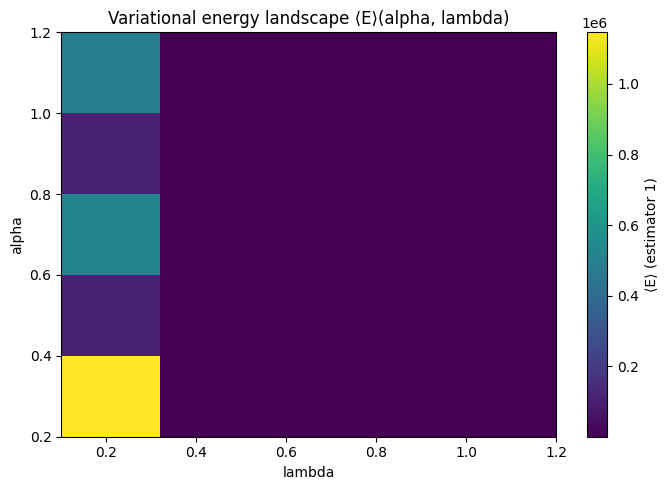

In [7]:
plt.figure(figsize=(7,5))
plt.imshow(
    Egrid,
    origin="lower",
    aspect="auto",
    extent=[lams[0], lams[-1], alphas[0], alphas[-1]]
)
plt.colorbar(label="⟨E⟩ (estimator 1)")
plt.xlabel("lambda")
plt.ylabel("alpha")
plt.title("Variational energy landscape ⟨E⟩(alpha, lambda)")
plt.tight_layout()
plt.show()

### E vs alpha at fixed lambda and E vs lambda at fixed alpha

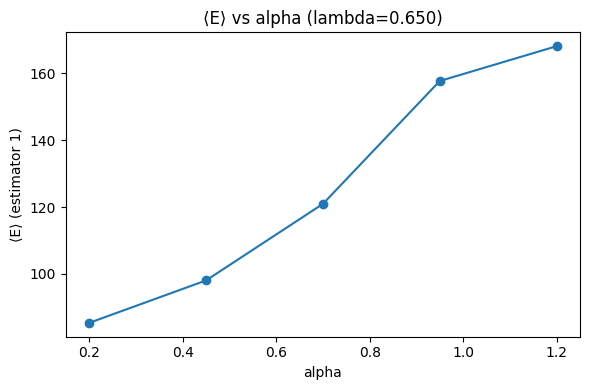

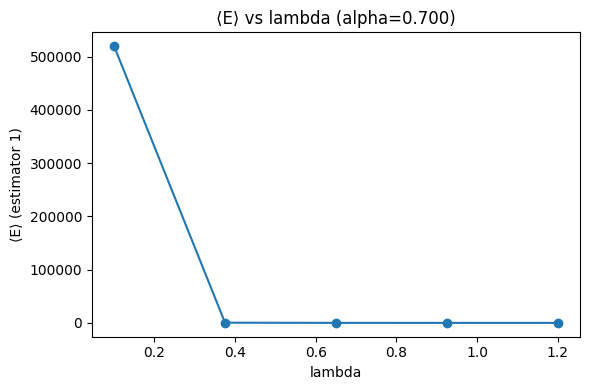

In [8]:
lam_mid = lams[len(lams)//2]
il_mid = len(lams)//2
plt.figure(figsize=(6,4))
plt.plot(alphas, Egrid[:, il_mid], marker="o")
plt.xlabel("alpha")
plt.ylabel("⟨E⟩ (estimator 1)")
plt.title(f"⟨E⟩ vs alpha (lambda={lam_mid:.3f})")
plt.tight_layout()
plt.show()

a_mid = alphas[len(alphas)//2]
ia_mid = len(alphas)//2
plt.figure(figsize=(6,4))
plt.plot(lams, Egrid[ia_mid, :], marker="o")
plt.xlabel("lambda")
plt.ylabel("⟨E⟩ (estimator 1)")
plt.title(f"⟨E⟩ vs lambda (alpha={a_mid:.3f})")
plt.tight_layout()
plt.show()

### Density profile at optimal parameters

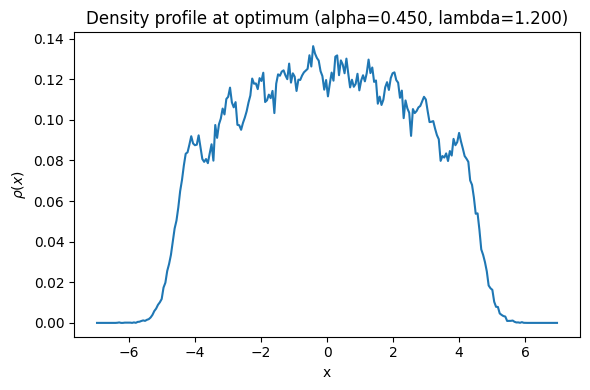

In [9]:
xg, rho = best_density
plt.figure(figsize=(6,4))
plt.plot(xg, rho, linewidth=1.5)
plt.xlabel("x")
plt.ylabel(r"$\rho(x)$")
plt.title(f"Density profile at optimum (alpha={best['alpha']:.3f}, lambda={best['lam']:.3f})")
plt.tight_layout()
plt.show()